In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})

# Ajustes en los archivos antes de procesar

In [3]:
vistas.rename(columns={"idAviso":"idaviso"}, inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-12 23:58:28.258806')

In [4]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-12 23:58:54.062677')

In [5]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

# Empieza el analisis

In [6]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [7]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [8]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [9]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [10]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [11]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,42.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


# Relacion entre cantidad de postulaciones y vistas por aviso

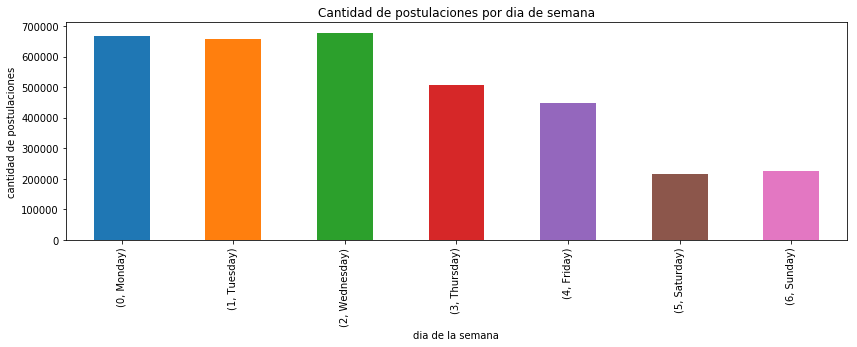

In [12]:
#cantidad de postulaciones por dia de semana
post_weekday = postulaciones
post_weekday['weekday'] = post_weekday['fechapostulacion'].dt.weekday_name
post_weekday['dayofweek'] = post_weekday['fechapostulacion'].dt.dayofweek
post_weekday_groupby = post_weekday.groupby(['dayofweek','weekday']).count()['fechapostulacion']
post_weekday_groupby.plot(title = "Cantidad de postulaciones por dia de semana",kind='bar',figsize=(14,4))
plt.xlabel('dia de la semana')
plt.ylabel('cantidad de postulaciones')
plt.show()

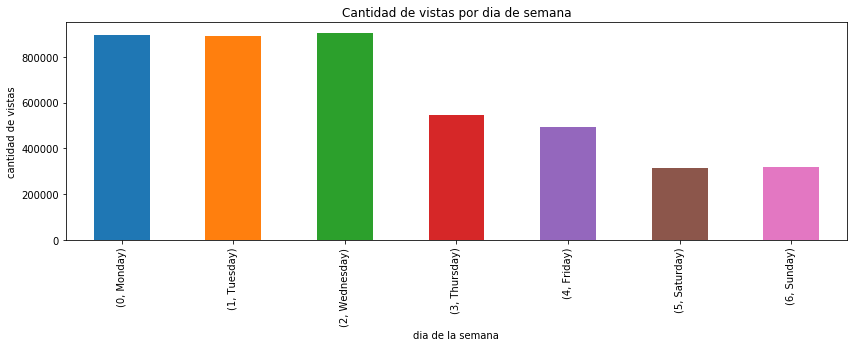

In [13]:
#cantidad de vistas por dia de semana
# se llego a la conclusion de que la cantidad de vistas totales son los registros del 
# archivo vistas + archivo postulaciones
vistas_weekday = postulaciones
vistas_weekday.rename(columns={"fechapostulacion":"fechavista"}, inplace=True)
vistas_weekday = pd.concat([vistas, vistas_weekday])
vistas_weekday['weekday'] = vistas_weekday['fechavista'].dt.weekday_name
vistas_weekday['dayofweek'] = vistas_weekday['fechavista'].dt.dayofweek
vistas_weekday_groupby = vistas_weekday.groupby(['dayofweek','weekday']).count()['fechavista']
vistas_weekday_groupby.plot(title = "Cantidad de vistas por dia de semana",kind='bar',figsize=(14,4))
plt.xlabel('dia de la semana')
plt.ylabel('cantidad de vistas')
plt.show()

In [14]:
#cantidad de postulaciones
avisos_cant_post = postulaciones.loc[:,['idaviso']]
avisos_cant_post = avisos_cant_post.groupby(['idaviso']).size()
avisos_cant_post = avisos_cant_post.sort_values(ascending=False)
avisos_cant_post = pd.DataFrame(avisos_cant_post).reset_index()
avisos_cant_post[["idaviso", "cant_post"]] = avisos_cant_post[["idaviso", 0]]
avisos_cant_post = avisos_cant_post[["idaviso", "cant_post"]]  
avisos_cant_post.head()

,idaviso,cant_post
0,1112033906,9932
1,1112334791,9787
2,1112204682,9244
3,1112094756,8763
4,1112345900,8304


In [15]:
avisos_cant_post.describe()

,idaviso,cant_post
count,1.269200e+04,12692.000000
mean,1.111419e+09,268.013158
std,2.084300e+07,542.269598
min,8.725750e+06,1.000000
25%,1.112229e+09,33.000000
50%,1.112276e+09,100.000000
75%,1.112321e+09,269.250000
max,1.112370e+09,9932.000000


In [16]:
# Para que los datos sean consistentes, filtro los datos menor al 25%, de cantidad 33 ya que el min es 1 y max 9932
avisos_cant_post = avisos_cant_post.loc[avisos_cant_post['cant_post']>=33,:]
avisos_cant_post.describe()

,idaviso,cant_post
count,9.550000e+03,9550.000000
mean,1.111534e+09,351.517382
std,2.052751e+07,602.175329
min,8.725750e+06,33.000000
25%,1.112247e+09,79.000000
50%,1.112286e+09,161.000000
75%,1.112325e+09,367.000000
max,1.112370e+09,9932.000000


In [17]:
#cantidad de vistas
avisos_cant_vistas = vistas.loc[:,['idaviso']]
avisos_cant_vistas = avisos_cant_vistas.groupby(['idaviso']).size()
avisos_cant_vistas = avisos_cant_vistas.sort_values(ascending=False)
avisos_cant_vistas = pd.DataFrame(avisos_cant_vistas).reset_index()
avisos_cant_vistas[["idaviso", "cant_vistas"]] = avisos_cant_vistas[["idaviso", 0]]
avisos_cant_vistas = avisos_cant_vistas[["idaviso", "cant_vistas"]]  
avisos_cant_vistas.head()

,idaviso,cant_vistas
0,1112363488,4169
1,1112359836,4120
2,1112352317,4003
3,1112366909,3669
4,1112355872,3472


In [18]:
#relacion post vs vistas
post_vs_vistas =  pd.merge(avisos_cant_post, avisos_cant_vistas, on="idaviso", how='inner')
post_vs_vistas = post_vs_vistas[["idaviso", "cant_post", "cant_vistas"]] 
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas
0,1112033906,9932,22
1,1112334791,9787,2817
2,1112204682,9244,18
3,1112094756,8763,6
4,1112345900,8304,2841


In [19]:
#cantidad vistas = cantidad de vistas + cantidad de postulaciones
post_vs_vistas['cant_vistas'] = post_vs_vistas.cant_vistas + post_vs_vistas.cant_post
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas
0,1112033906,9932,9954
1,1112334791,9787,12604
2,1112204682,9244,9262
3,1112094756,8763,8769
4,1112345900,8304,11145


In [20]:
#calculo la probabilidad de que alguien se postule
post_vs_vistas['prob_post'] = post_vs_vistas.cant_post / post_vs_vistas.cant_vistas
post_vs_vistas = post_vs_vistas.sort_values(by='prob_post', ascending=True)
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas,prob_post
5723,1112358876,33,308,0.107143
5404,1112366915,48,391,0.122762
5678,1112357526,36,291,0.123711
4747,1112364980,78,621,0.125604
4825,1112361132,74,564,0.131206


In [21]:
post_vs_vistas.describe()

,idaviso,cant_post,cant_vistas,prob_post
count,5.739000e+03,5739.000000,5739.000000,5739.000000
mean,1.111480e+09,441.203868,605.517860,0.729963
std,2.158131e+07,709.267394,912.459924,0.214954
min,1.254376e+07,33.000000,34.000000,0.107143
25%,1.112279e+09,101.000000,155.000000,0.601140
50%,1.112312e+09,208.000000,307.000000,0.766764
75%,1.112345e+09,466.000000,653.500000,0.904856
max,1.112370e+09,9932.000000,12604.000000,0.999836


In [22]:
# Para que los datos sean consistentes, filtro las probabilidades menor a 0.4 ya que el 25% es de cantidad 0.6 y el min es 0.1
post_vs_vistas = post_vs_vistas.loc[post_vs_vistas['prob_post']>=0.4,:]
post_vs_vistas.describe()

,idaviso,cant_post,cant_vistas,prob_post
count,5.095000e+03,5095.000000,5095.000000,5095.000000
mean,1.111439e+09,474.040824,609.567223,0.783122
std,2.274434e+07,742.757691,943.878570,0.162572
min,1.254376e+07,33.000000,34.000000,0.400000
25%,1.112275e+09,111.000000,146.000000,0.673172
50%,1.112307e+09,226.000000,295.000000,0.794326
75%,1.112337e+09,511.500000,650.500000,0.930348
max,1.112370e+09,9932.000000,12604.000000,0.999836


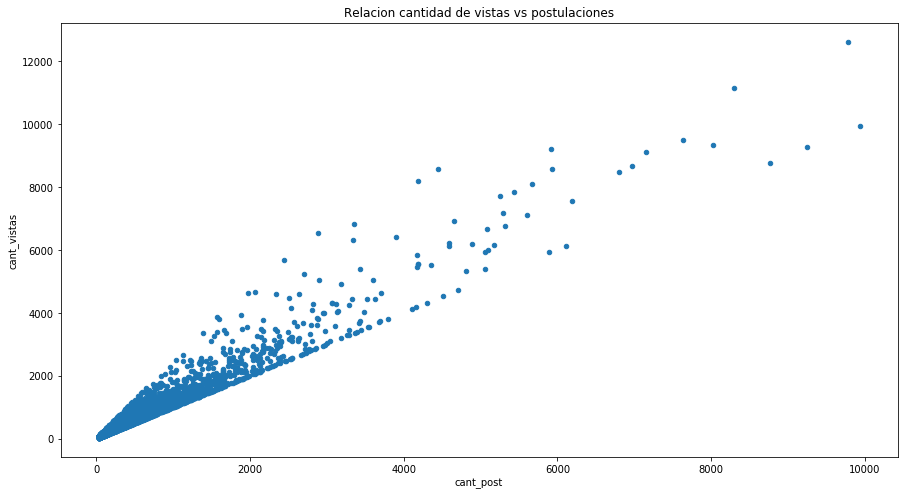

In [23]:
post_vs_vistas.plot.scatter('cant_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas vs postulaciones",figsize=(15,8));

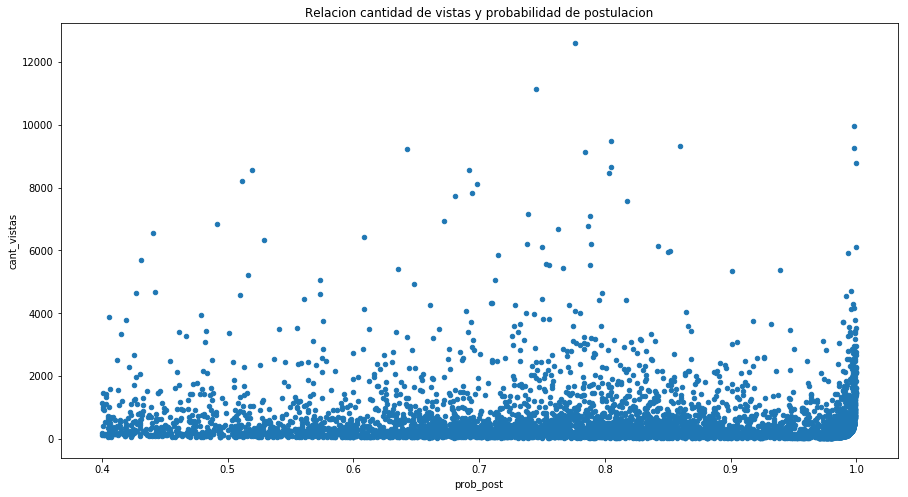

In [24]:
post_vs_vistas.plot.scatter('prob_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas y probabilidad de postulacion",figsize=(15,8));

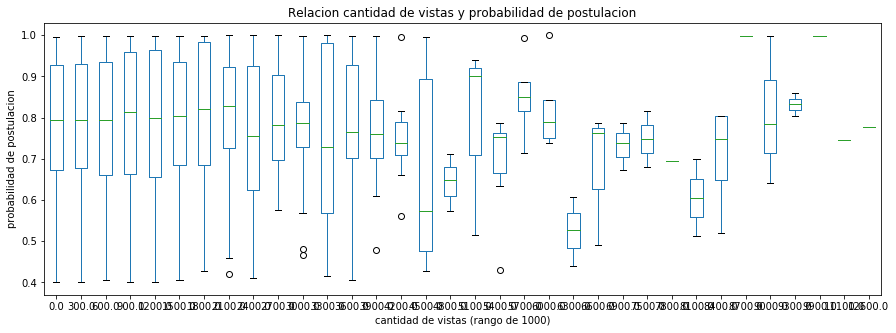

In [25]:
#relacion de cantidad de vistas con la probabilidad de postulacion
post_vs_vistas_box = post_vs_vistas
post_vs_vistas_box['cant_vistas_rg_mil'] = np.floor( post_vs_vistas['cant_vistas'].apply(lambda x: x /300) )
post_vs_vistas_box['cant_vistas_rg_mil'] = post_vs_vistas_box['cant_vistas_rg_mil'].apply(lambda x: x*300)
post_vs_vistas_box = post_vs_vistas_box.loc[:,['cant_vistas_rg_mil','prob_post']]
post_vs_vistas_box['subindex'] = post_vs_vistas_box.groupby('cant_vistas_rg_mil').cumcount() + 1
post_vs_vistas_box = pd.pivot_table(post_vs_vistas_box,index='subindex',columns='cant_vistas_rg_mil',values='prob_post')
post_vs_vistas_box.plot.box(title = "Relacion cantidad de vistas y probabilidad de postulacion", figsize=(15,5));
plt.xlabel('cantidad de vistas (rango de 1000)')
plt.ylabel('probabilidad de postulacion')
plt.show()

In [26]:
post_vs_vistas_detalle = post_vs_vistas.merge(avisos_detalles, on="idaviso")
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,cant_vistas_rg_mil,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112356141,78,195,0.400000,0.0,SOLDADOR-HERRERO Planta Gastronómica Mataderos...,"<p style="""">Food Service es una empresa 100% a...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Oficios y Profesiones,Food Service
1,1112357707,54,135,0.400000,0.0,"Jefe de Ventas, empresa química GBA","<p><strong>Spring Professional</strong>, headh...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Adecco - Spring Professional
2,1112358080,462,1154,0.400347,900.0,Administrativo Comercio Exterior Jr.,<p>Nos encontramos en la búsqueda de un admini...,Gran Buenos Aires,NaN,NaN,Full-time,Junior,Asesoría Legal y Comercio Internacional,Manpower
3,1111753347,593,1480,0.400676,1200.0,Oficiales Comerciales (Call Center),<p>Reconocida concesionaria Renault se encuent...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Galante D'Antonio SA
4,1112363817,170,424,0.400943,300.0,"CONFECCIÓN DE FACTURAS EN SISTEMA, SEGUIMIENTO...","<ul style=""""><li style="""">RECEPCIÓN, CONMUTADO...",Gran Buenos Aires,NaN,NaN,Full-time,Junior,Contabilidad y Administración,BZB ELECTROMECANICA SOCIEDAD RESPONSABILIDAD L...


In [27]:
#filtro campos importantes
post_vs_vistas_detalle = post_vs_vistas_detalle.loc[:, ['idaviso','cant_post','cant_vistas','prob_post','tipo_de_trabajo','nivel_laboral','nombre_area','denominacion_empresa']]
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112356141,78,195,0.400000,Full-time,Senior / Semi-Senior,Oficios y Profesiones,Food Service
1,1112357707,54,135,0.400000,Full-time,Senior / Semi-Senior,Comercial y Ventas,Adecco - Spring Professional
2,1112358080,462,1154,0.400347,Full-time,Junior,Asesoría Legal y Comercio Internacional,Manpower
3,1111753347,593,1480,0.400676,Full-time,Senior / Semi-Senior,Comercial y Ventas,Galante D'Antonio SA
4,1112363817,170,424,0.400943,Full-time,Junior,Contabilidad y Administración,BZB ELECTROMECANICA SOCIEDAD RESPONSABILIDAD L...
